For this Project I used AI to create Docstrings of the functions that I wrote, in order to help the reader understand and potentially use my functions.


In [90]:
import os

import matplotlib.pyplot as plt

import numpy as np

import skimage

from cv2 import COLOR_BGR2RGB  # ENUM for BGR to RGB
from cv2 import COLOR_RGB2BGR

from cv2 import VideoCapture  # For tranforming Video into Numpy array

from cv2 import VideoWriter  # For tranforming Numpy array back to Video

from cv2 import cvtColor  # For going from BGR to RGB

from cv2 import VideoWriter_fourcc
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from skimage import io
from cv2 import circle as cv2circle

Load Video


In [33]:
# def list_mp4_files():
#     # Get a list of MP4 files in the current directory
#     mp4_files = [file for file in os.listdir() if file.endswith(".mp4")]

#     if not mp4_files:
#         print("No MP4 files found in the current directory.")
#         return None

#     # Print the list of MP4 files with corresponding numbers
#     print("MP4 files in the current directory:")
#     for i, mp4_file in enumerate(mp4_files, start=1):
#         print(f"{i}. {mp4_file}")

#     # Prompt the user to choose a file by entering a number
#     while True:
#         try:
#             choice = int(input("Enter the number of the MP4 file you want to use: "))
#             if 1 <= choice <= len(mp4_files):
#                 return mp4_files[choice - 1]
#             else:
#                 print("Invalid choice. Please enter a valid number.")
#         except ValueError:
#             print("Invalid input. Please enter a number.")

In [171]:
# # List MP4 files and allow the user to choose one
# selected_mp4 = list_mp4_files()
# if selected_mp4:
#     # Load the selected MP4 video
#     path = os.path.join(os.getcwd(), selected_mp4)
path = os.path.join(os.getcwd(), "720p No occlusion 60fps Sahil CV demo_1.mp4")
frames = []

write_path = path[:-4] + "__firehands" + path[-4:]

cap = VideoCapture(path)

ret = True

while ret:

    ret, img = cap.read()  # read one frame from the 'capture' object; img is (H, W, C)

    if ret:

        frames.append(img)

video = np.stack(frames, axis=0)  # dimensions (T, H, W, C)

print(f"Number of Frames: {len(video)}")

print(f"Each frame is size: {video.shape[1:3]}")

Number of Frames: 510
Each frame is size: (720, 1280)


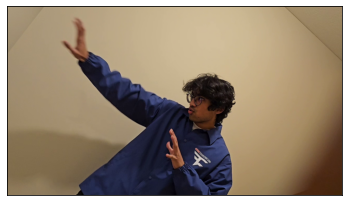

In [172]:
def show_frame(tframe, is_rgb = False):
    if not is_rgb:
        tframe = cvtColor(tframe, COLOR_BGR2RGB)

    fig, ax = plt.subplots()
    ax.imshow(tframe)
    # Remove axis ticks and labels for clarity
    ax.set_xticks([])
    ax.set_yticks([])


show_frame(video[70])

Mean Shift Tracking Code from HW6


In [36]:
def circularNeighbors(img, x, y, radius):
    """
    Extract circular neighbors around a given point in an image.

    Parameters:
    - img (numpy.ndarray): Input image.
    - x (int): x-coordinate of the center point.
    - y (int): y-coordinate of the center point.
    - radius (int): Radius of the circular region to extract neighbors.

    Returns:
    - X (numpy.ndarray): Array containing feature vectors of the circular neighbors.
      Each row in the array corresponds to a neighbor and contains [x-coordinate, y-coordinate, R, G, B].
    """

    height, width, _ = img.shape

    # Initialize an empty list to store feature vectors

    X = []


    # Loop through each pixel in a box neighborhood. We will check if it is in the circle using radius

    for xi in np.arange(x - radius, x + radius + 1, 1):

        for yi in np.arange(y - radius, y + radius + 1, 1):

            int_xi, int_yi = round(xi), round(yi)  # Get nearest pixel

            if (x - int_xi) ** 2 + (

                y - int_yi

            ) ** 2 < radius**2:  # Check within radius distance

                if 0 <= int_xi < width and 0 <= int_yi < height:  # Check within image

                    pixel = img[int_yi, int_xi]

                    R, G, B = pixel[0], pixel[1], pixel[2]

                    # print(np.sqrt((x - int_xi)**2 + (y - int_yi)**2))

                    # Create and append the feature vector to X

                    feature_vector = [int_xi, int_yi, R, G, B]

                    X.append(feature_vector)


    # Convert the list of feature vectors to a NumPy array

    X = np.array(X)


    return X

In [37]:
def colorHistogram(X, bins, x, y, h):
    """
    Compute the color histogram of a region around a given point in an image.

    Parameters:
    - X (numpy.ndarray): Array containing feature vectors of the circular neighbors.
      Each row in the array corresponds to a neighbor and contains [x-coordinate, y-coordinate, R, G, B].
    - bins (int): Number of bins for the histogram.
    - x (int): x-coordinate of the center point.
    - y (int): y-coordinate of the center point.
    - h (int): Size of the region to compute the histogram.

    Returns:
    - hist (numpy.ndarray): Color histogram of the specified region represented as a 3D cube.
      Each dimension corresponds to the bins for R, G, and B channels.
    """

    # Initialize an empty histogram cube

    hist = np.zeros((bins, bins, bins))


    # Calculate the bin size

    bin_size = 256 / bins


    # Loop through each pixel in the neighborhood

    for pixel in X:

        xi, yi, R, G, B = pixel


        # Calculate the Euclidian distance between the pixel and (x, y)

        distance = np.sqrt((xi - x) ** 2 + (yi - y) ** 2)

        # Calculate the Epanechnikov kernel weight

        weight = max(

            0, 1 - (distance / h) ** 2

        )  # this should never be 0 if h == radius right?


        # Calculate the bin indices for R, G, B

        R_bin = int(R // bin_size)

        G_bin = int(G // bin_size)

        B_bin = int(B // bin_size)


        # Increment the corresponding bin in the histogram cube

        hist[R_bin, G_bin, B_bin] += weight


    # Normalize the histogram so it sums to 1

    hist /= np.sum(hist)

    return hist

In [38]:
def meanshiftWeights(X, q_model, p_test, bins):
    """
    Compute the mean shift weights for a set of image pixels.

    Parameters:
    - X (numpy.ndarray): Array containing feature vectors of the circular neighbors.
      Each row in the array corresponds to a neighbor and contains [x-coordinate, y-coordinate, R, G, B].
    - q_model (numpy.ndarray): Color histogram of the model region.
    - p_test (numpy.ndarray): Color histogram of the test region.
    - bins (int): Number of bins for the histograms.

    Returns:
    - weights (numpy.ndarray): Mean shift weights for each pixel in the image.
      Each weight is computed as q_model[pixel] / p_test[pixel].
    """

    # Calculate the bin size

    bin_size = 256 / bins

    W = []

    # Loop through each pixel in the neighborhood

    for pixel in X:

        xi, yi, R, G, B = pixel

        R_bin = int(R // bin_size)

        G_bin = int(G // bin_size)

        B_bin = int(B // bin_size)


        W.append(q_model[R_bin, G_bin, B_bin] / p_test[R_bin, G_bin, B_bin])


    return np.sqrt(np.array(W))

In [39]:
def mean_shift(img1, img2, center, radius=25, bins=16, h=25, max_iter=25):
    """
    Perform mean shift tracking on two consecutive frames of a video.

    Parameters:
    - img1 (numpy.ndarray): First frame of the video.
    - img2 (numpy.ndarray): Second frame of the video.
    - center (tuple): Initial center coordinates (x, y) for tracking.
    - radius (int): Radius of the circular region for circular neighbors.
    - bins (int): Number of bins for color histograms.
    - h (int): Size of the region to compute histograms.
    - max_iter (int): Maximum number of iterations for mean shift.

    Returns:
    - y_final (tuple): Final estimated center coordinates after mean shift tracking.
    - distances (list): last two distances between consecutive iterations.
      The last two distances represent the convergence behavior.
    """

    qX = circularNeighbors(img1, *center, radius)

    q_model = colorHistogram(qX, bins, *center, h)

    y0 = center

    distance = []

    print(y0)
    for i in range(max_iter):

        pX = circularNeighbors(img2, *y0, radius)

        p_test = colorHistogram(pX, bins, *y0, h)

        W = meanshiftWeights(pX, q_model, p_test, bins)

        y1 = np.dot(W, pX[:, 0:2]) / np.sum(W)

        distance.append(np.sqrt((y0[0] - y1[0]) ** 2 + (y0[1] - y1[1]) ** 2))

        y0 = y1


    return y0, distance[-2:]

Run Mean Shift Tracking on a Hand on every frame

- How to handle when the mean shift tracking does not find any match?
- Things don't work well when hand is occluded by body or other hand.
- Frame rate of 30 fps might be too low, as the hands move a little too fast and escape the meanshift.


Solution - Get better video (60fps, 720p, no occclusion)

In [40]:
def track_hand(center: tuple, video: np.ndarray, start_frame=0, end_frame=None):
    """
    Track the position of a hand using mean shift tracking. Uses X and Y cordinates, not row and column.

    Parameters:
    - center (tuple): Initial position (x, y) of the hand in the first frame.
    - video (np.ndarray): Video frames in the form of a NumPy array.
    - start_frame (int, optional): The starting frame index for tracking. Default is 0.
    - end_frame (int, optional): The ending frame index for tracking. Default is None,
      which means tracking will continue until the last frame of the video.

    Returns:
    - positions (np.ndarray): A 2D NumPy array containing the hand positions in each frame.
      Each row represents a frame, and columns represent the x and y coordinates of the hand.
    """
    if end_frame is None:
        end_frame = video.shape[0]
    positions = np.zeros((video.shape[0], 2))
    positions[start_frame, :] = center
    for t in range(start_frame, end_frame - 1):
        img1, img2 = video[t], video[t + 1]
        im2pos, distances = mean_shift(img1, img2, center=positions[t], max_iter=50)
        positions[t + 1, :] = im2pos
    return positions

Grab Hand Centers using the gui tool I made with cv2 (pick_center.py)


In [41]:
right_hand_start = (554, 372)
left_hand_start = (530, 636)
radius = 25

Show starting hands


In [112]:
def draw_hand_circles(img, *, right_hand_coords, left_hand_coords, radius):
    """
    Draw circles around both hands on the given image.

    Parameters:
    - img (numpy.ndarray): Input image.
    - right_hand_coords (tuple): Coordinates (x, y) of the right hand.
    - left_hand_coords (tuple): Coordinates (x, y) of the left hand.
    - radius (int): Radius of the circles.

    Returns:
    - img_with_circles (numpy.ndarray): Image with circles drawn around both hands.
    """
    img = cvtColor(img, COLOR_BGR2RGB)

    # Convert coordinates to integers just in case
    right_hand_coords = tuple(map(int, right_hand_coords))
    left_hand_coords = tuple(map(int, left_hand_coords))

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Draw circles around both hands
    right_circle = Circle(
        right_hand_coords,
        radius,
        edgecolor="r",
        facecolor="none",
        linewidth=2,
        # label="Right hand",
    )
    left_circle = Circle(
        left_hand_coords,
        radius,
        edgecolor="b",
        facecolor="none",
        linewidth=2,
        # label="Left hand",
    )

    ax.add_patch(right_circle)
    ax.add_patch(left_circle)

    # # Set axis limits to fit the circles (This didn't do anything)
    # ax.set_xlim([0, img.shape[1]])
    # ax.set_ylim([img.shape[0], 0])

    # Remove axis ticks and labels for clarity
    ax.set_xticks([])
    ax.set_yticks([])
    # Create custom legend handles with circles
    legend_handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markeredgecolor="r",
            markerfacecolor="none",
            markersize=10,
            linewidth=0,
            label="Right Hand",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markeredgecolor="b",
            markerfacecolor="none",
            markersize=10,
            linewidth=0,
            label="Left Hand",
        ),
    ]
    ax.legend(handles=legend_handles)
    plt.show()

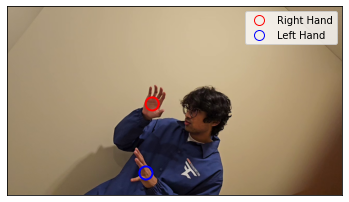

In [106]:
draw_hand_circles(
    video[0],
    right_hand_coords=right_hand_start,
    left_hand_coords=left_hand_start,
    radius=radius,
)

In [44]:
right_hand_pos = track_hand(right_hand_start, video)

[554. 372.]
[552.21249564 371.75722444]
[549.17793056 370.42743828]
[548.26113116 368.69189921]
[544.06585745 367.77784829]
[543.67179993 364.17294221]
[542.31156009 360.68653243]
[540.6756308  357.26724828]
[538.91489988 353.52747144]
[537.3063068  350.32125594]
[535.36447058 347.32569797]
[533.7492783  343.25381814]
[532.27565661 340.24187264]
[531.59327963 336.61353134]
[530.7066133  333.22170012]
[528.65611586 331.66860217]
[527.55361058 329.51889079]
[527.43448784 327.1775245 ]
[526.03503051 326.17420491]
[525.56357673 325.4553076 ]
[525.01312257 325.45057253]
[525.26268512 325.11948788]
[525.17875246 325.92422864]
[524.75250963 327.39208589]
[525.16338062 328.98272253]
[525.76613248 329.91695053]
[526.4907779  331.99731145]
[526.6375714  334.71545156]
[527.31489681 336.6929393 ]
[529.48508427 337.96252671]
[531.27964447 339.54431615]
[532.92807673 340.8057357 ]
[534.89648403 341.11665966]
[537.79279119 341.62170018]
[540.35881427 342.31876583]
[542.92224026 342.16039981]
[545.412

In [50]:
left_hand_pos = track_hand(left_hand_start, video)

[530. 636.]
[529.31910576 633.46511817]
[530.03163773 629.5790547 ]
[530.71489288 627.29124986]
[532.3636664  622.75652098]
[534.51327029 616.20888463]
[537.62456874 609.30954537]
[542.54611925 603.44267825]
[546.33140295 595.12373018]
[550.48379585 588.4549425 ]
[554.3922002 580.2014453]
[559.13498068 574.06949583]
[564.26429394 571.28850824]
[567.16546897 565.66401324]
[570.29188571 562.70344138]
[572.09927697 560.14023063]
[573.75025476 559.48933882]
[574.93113533 559.79890737]
[575.21149402 560.41373483]
[574.71780174 561.6849655 ]
[573.29902336 564.76034001]
[570.50065743 567.74205987]
[568.24736612 573.84296049]
[565.82322302 579.68214474]
[563.21865069 587.65486056]
[559.35985788 593.69391535]
[556.93885864 599.90943274]
[555.55458447 604.69169017]
[553.87655511 606.95728503]
[553.94851867 608.86542854]
[555.2014257  610.43323334]
[555.5581143 608.449218 ]
[557.74736852 607.25597848]
[560.32500213 605.32491426]
[564.71053897 605.33674236]
[567.49426018 603.53394863]
[570.8475988

In [49]:
right_hand_pos

array([[554.        , 372.        ],
       [552.21249564, 371.75722444],
       [549.17793056, 370.42743828],
       ...,
       [466.40589679, 355.93339441],
       [459.35782656, 359.25156935],
       [452.59975238, 362.35283207]])

Calculate Speeds and create trigger arrays for both hands


In [216]:
def calculate_single_hand_movement(single_hand_positions):
    """
    Calculate the direction and magnitude of a single hand's movement at each frame.

    Parameters:
    - single_hand_positions (numpy.ndarray): Array of hand positions for each frame.
      Each row should represent the x, y coordinates of a hand for a specific frame.

    Returns:
    - hand_movement (numpy.ndarray): Array of tuples containing direction and magnitude for each frame.
    """
    hand_movement = np.zeros((len(single_hand_positions), 2))

    for i in range(1, len(single_hand_positions)):
        delta_pos = single_hand_positions[i] - single_hand_positions[i - 1]

        # Calculate magnitude and direction (angle in degrees)
        magnitude = np.linalg.norm(delta_pos)
        direction = np.arctan2(delta_pos[1], delta_pos[0]) * (180 / np.pi)

        hand_movement[i] = (direction, magnitude)
        # if i == 3:
        #     print(hand_movement[i])

    return hand_movement

In [236]:
def calculate_firesize_and_direction(
    *, left_hand_positions, right_hand_positions, low_speed_threshold=0.3
):
    """
    Calculate normalized hand velocities (direction and magnitude) based on hand movement positions.

    Parameters:
    - left_hand_positions (numpy.ndarray): Array of hand positions for the left hand for each frame.
      Each row should represent the x, y coordinates of the left hand for a specific frame.
    - right_hand_positions (numpy.ndarray): Array of hand positions for the right hand for each frame.
      Each row should represent the x, y coordinates of the right hand for a specific frame.
    - low_speed_threshold (float): Threshold to set speeds to zero for slower movements.

    Returns:
    - left_hand_velocities (numpy.ndarray): Array of normalized hand velocities (direction and magnitude)
    for the left hand.
    - right_hand_velocities (numpy.ndarray): Array of normalized hand velocities (direction and magnitude)
    for the right hand.
    """
    left_hand_velocities = calculate_single_hand_movement(left_hand_positions)
    right_hand_velocities = calculate_single_hand_movement(right_hand_positions)

    max_speed = max(
        [np.max(left_hand_velocities[:, 1]), np.max(right_hand_velocities[:, 1])]
    )
    actual_speed_thresh = max_speed * low_speed_threshold
    # Set speeds below the low_speed_threshold to zero
    left_hand_velocities[left_hand_velocities[:, 1] < actual_speed_thresh, 1] = 0
    right_hand_velocities[right_hand_velocities[:, 1] < actual_speed_thresh, 1] = 0

    # Shift and scale non-zero speeds to the range (0, 1]
    left_non_zero = left_hand_velocities[:, 1] > 0
    right_non_zero = right_hand_velocities[:, 1] > 0
    min_speed = min(
        np.min(left_hand_velocities[left_non_zero, 1]),
        np.min(right_hand_velocities[right_non_zero, 1]),
    )
    speed_range = max_speed - min_speed
    left_hand_velocities[left_non_zero, 1] = (left_hand_velocities[left_non_zero, 1] - min_speed) / speed_range
    right_hand_velocities[right_non_zero, 1] = (right_hand_velocities[right_non_zero, 1] - min_speed) / speed_range
    return left_hand_velocities, right_hand_velocities, speed_range, min_speed

In [451]:
def is_moving_towards_median(current_position, median_position, velocity):
    """
    Check if the hand is moving towards the median location.

    Parameters:
    - current_position (numpy.ndarray): Current position (x, y) of the hand.
    - median_position (numpy.ndarray): Median position (x, y) of the hand.
    - velocity (numpy.ndarray): Velocity vector (dx, dy) of the hand.

    Returns:
    - moving_towards_median (bool): True if the hand is moving towards the median, False otherwise.
    """
    displacement_vector = median_position - current_position
    displacement_normalized = displacement_vector / np.linalg.norm(displacement_vector)
    velocity_normalized = velocity / np.linalg.norm(velocity)

    dot_product = np.dot(displacement_normalized, velocity_normalized)

    # If the dot product is positive, the hand is moving towards the median
    moving_towards_median = dot_product > 0

    return moving_towards_median

In [453]:
def detect_detach(
    *,
    left_velocities,
    right_velocities,
    left_median,
    left_max_stray,
    right_median,
    right_max_stray,
    left_pos,
    right_pos,
    high_speed_threshold=0.7,
    angle_change_threshold=90
):
    """
    Detect detachment of the fireball from each hand based on high speed and velocity direction.
    When high speed suddenly drops to 0 or reverses direction in the previous frame, detach will be triggered.

    Parameters:
    - hand_positions (numpy.ndarray): Array of hand positions for each frame.
      Each row should represent the x, y coordinates of a hand for a specific frame.
    - high_speed_threshold (float): Threshold for FAST movements before the detach.
    - threshold_angle (float): Threshold for the angle change to detect detachment.

    Returns:
    - detach_frames_left (numpy.ndarray): Boolean array indicating detachment frames for the left hand.
    - detach_frames_right (numpy.ndarray): Boolean array indicating detachment frames for the right hand.
    """

    detach_frames_left = np.zeros(len(left_velocities), dtype=bool)
    detach_frames_right = np.zeros(len(right_velocities), dtype=bool)

    def detach_helper_check(velocity_pre, velocity_post, med, max_stray, pos):
        # Calculate the distance from each hand to its median location
        distance = np.linalg.norm(pos - med) 
        # Adjust the speed threshold based on distance from median location
        adjusted_speed_threshold = high_speed_threshold * (1 - 0.5 * distance/ max_stray)
        speed_check = (velocity_pre[1] >= adjusted_speed_threshold) and velocity_post[
            1
        ] < adjusted_speed_threshold
        # angle_check = abs(velocity_post[0] - velocity_pre[0]) >= angle_change_threshold
        return speed_check and not is_moving_towards_median(pos, med, velocity_pre) #or angle_check 

    for i in range(0, len(left_velocities) - 1):
        detach_frames_left[i] = detach_helper_check(*left_velocities[i : i + 2], left_median, left_max_stray, left_hand_pos[i])
        detach_frames_right[i] = detach_helper_check(*right_velocities[i : i + 2], right_median, right_max_stray, right_hand_pos[i])

    return detach_frames_left, detach_frames_right

Class for detatched Fireball

In [474]:
class DetachedFireball:
    static_speed_range = 1
    static_speed_min = 1
    def __init__(self, center, raw_speed, direction, colors, time_detached):
        self.center = center
        self.raw_speed = raw_speed
        self.move_speed = raw_speed * DetachedFireball.static_speed_range + DetachedFireball.static_speed_min
        self.direction = direction
        self.colors = colors
        self.time_detached = time_detached

    def update_position(self):
        """
        Update the position of the fireball based on raw speed and direction.
        Modifies the center attribute in-place.
        """
        new_x = self.center[0] + int(self.move_speed * np.cos(np.radians(self.direction)))
        new_y = self.center[1] + int(self.move_speed * np.sin(np.radians(self.direction)))

        self.center = (new_x, new_y)

In [475]:
def calculate_median_and_max_distance(hand_positions):
    """
    Calculate the median position and max distance from median for a hand's positions.

    Parameters:
    - hand_positions (numpy.ndarray): Array of hand positions for each frame.
      Each row should represent the x, y coordinates of a hand for a specific frame.

    Returns:
    - median_position (tuple): Median position (x, y) of the hand.
    - max_distance (float): Maximum distance from the median position.
    """
    median_position = np.median(hand_positions, axis=0)
    distances = np.linalg.norm(hand_positions - median_position, axis=1)
    max_distance = np.max(distances)

    return median_position, max_distance

In [476]:
import cv2


def add_flames(
    left_hand_pos,
    right_hand_pos,
    video,
    low_speed_threshold=0.3,
    high_speed_threshold=0.7,
    angle_change_threshold=90,
    flame_size=100,
    cooldown_period=5,
):
    """
    Add flames to video frames based on firesize, and detach them based on trigger values.

    Parameters:
    - left_hand_pos (numpy.ndarray): Array of left hand positions for each frame.
      Each row should represent the x, y coordinates of the left hand for a specific frame.
    - right_hand_pos (numpy.ndarray): Array of right hand positions for each frame.
      Each row should represent the x, y coordinates of the right hand for a specific frame.
    - video (numpy.ndarray): Array representing the video frames.
    - ##FIX
    """
    (
        left_velocities,
        right_velocities,
        speed_range,
        min_speed,
    ) = calculate_firesize_and_direction(
        left_hand_positions=left_hand_pos,
        right_hand_positions=right_hand_pos,
        low_speed_threshold=low_speed_threshold,
    )
    DetachedFireball.static_speed_range = speed_range
    DetachedFireball.static_speed_min = min_speed
    left_median, left_max_stray = calculate_median_and_max_distance(left_hand_pos)
    right_median, right_max_stray = calculate_median_and_max_distance(right_hand_pos)

    detach_frames_left, detach_frames_right = detect_detach(
        left_velocities=left_velocities,
        right_velocities=right_velocities,
        left_median=left_median,
        left_max_stray=left_max_stray,
        right_median=right_median,
        right_max_stray=right_max_stray,
        left_pos=left_hand_pos,
        right_pos=right_hand_pos,
        high_speed_threshold=high_speed_threshold,
        angle_change_threshold=angle_change_threshold,
    )
    video_with_flames = np.copy(video)

    int_left_hand_pos = np.round(left_hand_pos).astype(int)
    int_right_hand_pos = np.round(right_hand_pos).astype(int)

    # Detach Cooldowns
    left_cooldown = 0
    right_cooldown = 0
    print(right_velocities[107:110])
    print(np.where(detach_frames_left))
    # print(min_speed)
    # print(left_velocities)

    colors_left = [
        (0, 255, 255),  # Yellow
        (0, 165, 255),  # Orange
        (0, 0, 255),  # Red
    ]
    colors_right = [
        (255, 0, 0),  # Blue
        (255, 255, 0),  # Cyan
        (255, 255, 255),  # White
    ]
    detached_fireballs = []
    for i in range(len(video)):
        # Make a copy of the frame to avoid modifying the original (Just for sanity)
        frame = video[i].copy()

        # Draw flames on the left hand with a combination of yellow, orange, and red
        # Scale the radius based on magnitude
        frame, left_cooldown = single_hand_flame(
            flame_size,
            cooldown_period,
            left_velocities[i],
            detach_frames_left[i],
            int_left_hand_pos[i],
            left_cooldown,
            colors_left,
            frame,
            detached_fireballs,
            time=i,
        )
        frame, right_cooldown = single_hand_flame(
            flame_size,
            cooldown_period,
            right_velocities[i],
            detach_frames_right[i],
            int_right_hand_pos[i],
            right_cooldown,
            colors_right,
            frame,
            detached_fireballs,
            time=i,
        )

        # Display the frame or save it to a new video file as needed
        video_with_flames[i] = frame
    video_with_flames = draw_detached(flame_size, video_with_flames, detached_fireballs)
    return video_with_flames


def single_hand_flame(
    flame_size,
    cooldown_period,
    velocity,
    detach,
    int_hand_pos,
    cooldown,
    colors,
    frame,
    detached_fireballs,
    time,
):
    flame_radius = int(flame_size * velocity[1])
    # print(flame_radius)
    if cooldown > 0:
        cooldown -= 1
        flame_radius /= 2

    for j, color in enumerate(colors):
        # Decrease alpha for blending
        alpha = int(255 * (1 - (j + 1) / (len(colors) + 1)))
        blended_color = tuple(
            np.round(
                np.multiply(color, alpha / 255)
                + frame[int_hand_pos[1], int_hand_pos[0]] * (1 - alpha / 255)
            ).astype(int)
        )
        # convert data types int64 to int
        blended_color = tuple(map(int, blended_color))

        cv2.circle(
            frame,
            tuple(int_hand_pos),
            int(max(flame_radius * (1 - j / len(colors)), 0)),
            tuple(blended_color),
            -1,
        )
        # Detach Code Here
        if cooldown == 0 and detach:
            cooldown = cooldown_period
            detached_fireball = DetachedFireball(
                center=(int_hand_pos[0], int_hand_pos[1]),
                raw_speed=velocity[1],
                direction=velocity[0],
                colors=colors,
                time_detached=time,
            )
            detached_fireballs.append(detached_fireball)

    return frame, cooldown


def draw_detached(flame_size, video, detached_fireballs: list[DetachedFireball]):
    h, w, *_ = video[0].shape
    detached_video = video.copy()
    for fireball in detached_fireballs:
        frame_idx = fireball.time_detached
        x, y = map(int,fireball.center)
        time = 0
        while frame_idx < len(detached_video) and 0 <= x <= w and 0 <= y <= h:
            frame = detached_video[frame_idx]
            # draw
            flame_radius = int(flame_size * fireball.raw_speed)
            alpha = int(255 * (1 - time / len(video)))
            for j, color in enumerate(fireball.colors):
                blended_color = tuple(
                    np.round(
                        np.multiply(color, alpha / 255)
                        + frame[y, x] * (1 - alpha / 255)
                    ).astype(int)
                )
                blended_color = tuple(map(int, blended_color))

                # Draw the fireball on the frame
                cv2.circle(
                    frame,
                    (x, y),
                    int(max(flame_radius * (1 - j / len(fireball.colors)), 0)),
                    tuple(blended_color),
                    -1,
                )
            # update fireball and time passed
            time += 1
            fireball.update_position()
            x, y = map(int,fireball.center)
            frame_idx += 1
    return detached_video

Here is where the fireballs actually are drawn in

In [477]:
fire_hands = add_flames(left_hand_pos, right_hand_pos, video)

[[-154.36270138    0.38763074]
 [-162.99226187    0.45050277]
 [-163.05002053    0.25510482]]
(array([176, 268], dtype=int64),)


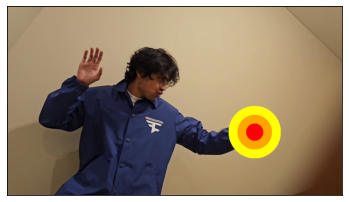

In [481]:
show_frame(fire_hands[268])

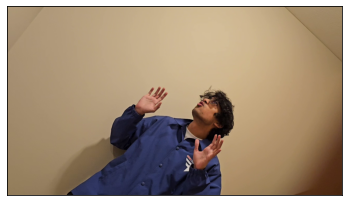

In [282]:
show_frame(fire_hands[430])

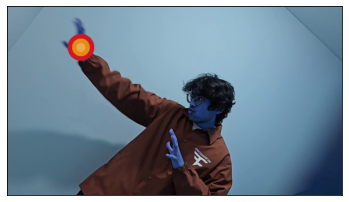

In [293]:
tframe = cvtColor(fire_hands[70], COLOR_RGB2BGR)

show_frame(tframe)

Write finished product to Video File


In [480]:
# let `video` be an array with dimensionality (T, H, W, C)
num_frames, height, width, _ = video.shape

filename = "test_out_detaching.mp4"
codec_id = "mp4v"  # ID for a video codec.
fourcc = VideoWriter_fourcc(*codec_id)
out = VideoWriter(
    filename, fourcc=fourcc, fps=60, frameSize=(width, height), isColor=True
)

for frame in fire_hands:
    out.write(frame)
# Release the video writer object
out.release()